In [2]:
from info_nas.datasets.networks.pretrained import pretrain_network_cifar
from info_nas.datasets.networks.utils import load_nasbench
from nasbench_pytorch.datasets.cifar10 import prepare_dataset

In [3]:
seed = 42
batch_size = 32
num_workers = 2

dataset = prepare_dataset(batch_size, root='../data/cifar/', validation_size=1000, random_state=seed,
                          num_workers=num_workers)
train, n_train, val, n_val, test, n_test = dataset


--- Preparing CIFAR10 Data ---
Files already downloaded and verified
Files already downloaded and verified
--- CIFAR10 Data Prepared ---



In [4]:
import os

checkpoint_dir = '../data/train_checkpoints//'

os.listdir(f'{checkpoint_dir}')

['023bfb8418a28942ee4a9734e373ca67.tar',
 '083a8045a46ac2a25a34c8fab47f6ecb.tar',
 '23b8304199794a8eb423def3bd0c343d.tar',
 '663737f875418ec3838f2c9eadca7b50.tar']

In [5]:
from nasbench import api

nasbench_path = '../data/nasbench_only108.tfrecord'
nb = api.NASBench(nasbench_path)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 34 seconds


In [6]:
import torch
from info_nas.datasets.networks.utils import load_trained_net

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net_path = f'{checkpoint_dir}083a8045a46ac2a25a34c8fab47f6ecb.tar'
net_hash, net, info = load_trained_net(net_path, nb, device=device)
net

Network(
  (layers): ModuleList(
    (0): ConvBnRelu(
      (conv_bn_relu): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Cell(
      (vertex_op): ModuleList(
        (0): None
        (1): MaxPool3x3(
          (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        )
        (2): Conv3x3BnRelu(
          (conv3x3): ConvBnRelu(
            (conv_bn_relu): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
        )
        (3): MaxPool3x3(
          (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        )
        

In [7]:
info

{'train_loss': tensor(0.2445, device='cuda:0'),
 'train_accuracy': tensor(0.9148, device='cuda:0'),
 'val_loss': tensor(0.3229, device='cuda:0'),
 'val_accuracy': tensor(0.8910, device='cuda:0'),
 'test_loss': tensor(0.3741, device='cuda:0'),
 'test_accuracy': tensor(0.8813, device='cuda:0')}

In [19]:
torch.cat([net.classifier.weight, net.classifier.bias.unsqueeze(-1)], dim=1).shape

RuntimeError: Tensors must have same number of dimensions: got 1 and 2

In [11]:
net.classifier.bias

Parameter containing:
tensor([ 0.2086, -0.3433,  0.1516,  0.3202,  0.1540, -0.0996, -0.0075,  0.0369,
        -0.1386, -0.2822], device='cuda:0', requires_grad=True)

- heatmaps todo
  - all net weights for e.g. airplane
  - minmaxscale to (-1,1), compare net
    - bias?
  - standardscale instead of normalize
  - predict one image, sort values by weights
    - how to normalize??

<IPython.core.display.Javascript object>


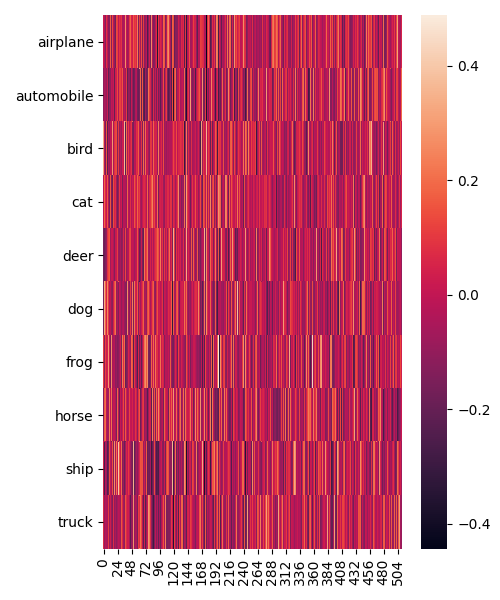

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

labels = "airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck".split(', ')

weights = net.classifier.weight.detach().cpu()

plt.figure(figsize=(5,6))
sns.heatmap(weights, yticklabels=labels)
#plt.imshow(net.classifier.weight.detach().cpu())
plt.tight_layout()
plt.savefig('cifar_weights.png')
plt.show()

In [36]:
for batch_idx, (inputs, targets) in enumerate(val):
    inputs, targets = inputs.to(device), targets.to(device)
    break
    
print(inputs.shape)
print(targets.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])
